# ODE Lab III: Advanced Topics

## The Double Pendulum Problem

The double pendulum is a well known example of a non-linear, chaotic system in classical mechanics.
It consists of a pendulum with another pendulum attached to its end, resulting in a system with two degrees of freedom.
This configuration leads to highly complex and sensitive-dependent dynamics, making the double pendulum an excellent subject for studying chaos theory and non-linear dynamics.
Because it is not possible to construct analytical solutions, it is also a great example to numerical integrators.

![Double pendulum](https://upload.wikimedia.org/wikipedia/commons/c/c9/Double-compound-pendulum-dimensioned.svg)

The equation of motion for double pendulum is pretty ugly.
To set up the equations, we assume:

* The two arms of the pendulums have the same length $l$.
* The mass of each arm is $m$.
* The angle between the first and second pendulums, with respect to the vertical axis, are denoted by $\theta_1$ and $\theta_2$.

Newton's second law suggests that we will need to solve a system of two second-order ordinary differential equations (ODEs).
Using the methods we learn in the lecture, we can cast the problem into a system of four first-order ODEs.
\begin{align}
\frac{d\theta_1}{dt} &=
\frac{6}{m l^2}\frac{2 p_1 - 3 \cos(\theta_1 - \theta_2) p_2}{16 - 9 \cos^2(\theta_1 - \theta_2)}\\
\frac{d\theta_2}{dt} &=
\frac{6}{m l^2}\frac{8 p_2 - 3 \cos(\theta_1 - \theta_2) p_1}{16 - 9 \cos^2(\theta_1 - \theta_2)}\\
\frac{dp_1}{dt} &=
-\frac{1}{2} m l^2 \left(\frac{d\theta_1}{dt} \frac{d\theta_2}{dt}\sin(\theta_1 - \theta_2) +
                           3\frac{g}{l}\sin\theta_1\right)\\
\frac{dp_2}{dt} &=
-\frac{1}{2} m l^2 \left(-\frac{d\theta_1}{dt} \frac{d\theta_2}{dt}\sin(\theta_1 - \theta_2) +
                            \frac{g}{l}\sin\theta_2\right)
\end{align}
where $p_1$ and $p_2$ are called the generalized momenta.
(There might be typos in the equation.
Please [double check](https://en.wikipedia.org/wiki/Double_pendulum).)

It would be impossible to implement this in a few minutes as a hands-on exercise!

Thankfully, we have just learned computational Lagrangian mechanics in class using autodiff and ODE integrator.
The Lagrangian of the double pendulum system is:
\begin{align}
L 
&= \frac{1}{2} m\left(v_1^2 + v_2^2\right)
 + \frac{1}{2}I\left(\dot\theta_1^2 + \dot\theta_2^2\right) - mg (y_1 + y_2) \\
&= \frac{1}{6} m l^2 \left(4\dot\theta_1^2 + \dot\theta_2^2 + 3\dot\theta_1\dot\theta_2\cos(\theta_1 - \theta_2)\right)
 + \frac{1}{2} mgl \left(3\cos\theta_1 + \cos\theta_2\right)
\end{align}
We will use this to implement a solver in this hands-on lab.

In [1]:
! pip install jax


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import jax
jax.config.update("jax_enable_x64", True)

In [3]:
from jax import numpy as np

In [18]:
# Step 1. Copy an ODE Integrator from the class note

a =[
    [],
    [1/5],
    [3/40, 9/40],
    [44/45, -56/15, 32/9],
    [19372/6561, -25360/2187, 64448/6561, -212/729],
    [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656],
    [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84],
]

b_high = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0] # Fifth-order accurate solution estimate
b_low  = [5179/57600, 0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40] # Fourth-order accurate solution estimate

c = [0, 1/5, 3/10, 4/5, 8/9, 1, 1]

def DP45_step(f, x, t, dt):
        # Compute intermediate k1 to k7
    k1 = f(x)
    k2 = f(x + dt*(a[1][0]*k1))
    k3 = f(x + dt*(a[2][0]*k1 + a[2][1]*k2))
    k4 = f(x + dt*(a[3][0]*k1 + a[3][1]*k2 + a[3][2]*k3))
    k5 = f(x + dt*(a[4][0]*k1 + a[4][1]*k2 + a[4][2]*k3 + a[4][3]*k4))
    k6 = f(x + dt*(a[5][0]*k1 + a[5][1]*k2 + a[5][2]*k3 + a[5][3]*k4 + a[5][4]*k5))
    k7 = f(x + dt*(a[6][0]*k1 + a[6][1]*k2 + a[6][2]*k3 + a[6][3]*k4 + a[6][4]*k5 + a[6][5]*k6))

    ks = [k1, k2, k3, k4, k5, k6, k7]

    # Compute high and low order estimates
    x_high = x
    for b, k in zip(b_high, ks):
        x_high += dt * b * k

    x_low  = x 
    for b, k in zip(b_low, ks):
        x_low += dt * b * k

    return x_high, x_low, ks

def dt_update(dt, error, tol, fac=0.9, fac_min=0.1, fac_max=4.0, alpha=0.2):
    if error == 0:
        s = fac_max
    else:
        s = fac * (tol / error) ** alpha
    s = min(fac_max, max(fac_min, s))
    dt_new = dt * s
    return dt_new

def odeint(f, x0, t0, t1, dt=0.1, atol=1e-6, rtol=1e-6):
    
    Ts = [t0]
    Xs = [np.array(x0)]

    while t0 < t1:
        if t0 + dt > t1:
            dt = t1 - t0  # Adjust step size to end exactly at tf

        # Perform a single Dormand–Prince step
        x_high, x_low, _ = DP45_step(f, x0, t0, dt)

        # Compute the error estimate
        error = np.linalg.norm(x_high - x_low, ord=np.inf)

        # Compute the tolerance
        tol = atol + rtol * np.linalg.norm(x_high, ord=np.inf)

        # Check if the step is acceptable
        if error <= tol:
            # Accept the step
            t0 += dt
            x0 = x_high
            Ts.append(t0)
            Xs.append(x0)

        # Compute the new step size
        dt = dt_update(dt, error, tol)

    return np.array(Ts), np.array(Xs)

In [7]:
# Step 2. Copy ELrhs() from the class note

from jax import grad, jacfwd, jit
from jax.numpy.linalg import inv

def ELrhs(L):
    
    Lx  = grad(L, argnums=0)
    Lv  = grad(L, argnums=1)
    Lvp = jacfwd(Lv, argnums=(0,1))

    @jit
    def rhs(xv):
        x,   v   = xv
        Lvx, Lvv = Lvp(x, v)
        a = inv(Lvv) @ (Lx(x, v) - v @ Lvx)
        return np.array([v, a])

    return rhs

In [11]:
# Step 3. Combine ELrhs() with the ODE Integrator.  See, e.g., path() from class

def path(L, xv0, t0, t1, dt=0.1, atol=1e-6, rtol=1e-6):
    return odeint(ELrhs(L), xv0, t0, t1, dt, atol, rtol) # <- make sure it is compatible with the ODE integrator you choose

In [9]:
# Step 4. Implement the Lagrangian of the double pendulum

def L(x, v):
    x1, x2 = x
    v1, v2 = v
    m  = 1
    l  = 1
    g  = 1
    L=(1/6)*m*(l**2) * (4*(v1**2) + (v2**2) + 3*v1*v2*np.cos(x1-x2)) + (1/2)*m*g*l * (3*np.cos(x1) + np.cos(x2))
    return L

In [19]:
# Step 5. Use path() to solve the problem

xv0   = np.array([[np.pi/2,np.pi/2], [0.0,0.0]])
T, XV = path(L, xv0, 0.0, 10.0)

X = XV[:,0,:]
V = XV[:,1,:]

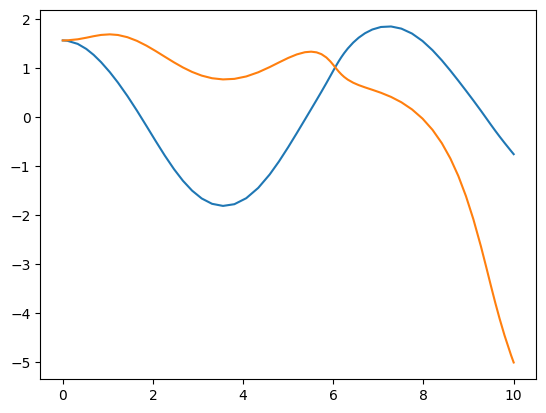

In [ ]:
# Step 6. Plot the result

from matplotlib import pyplot as plt

plt.plot(T,X)

In [21]:
# Step 7. Animate the result

from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
ax  = plt.axes(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))
ax.set_aspect('equal')

line, = ax.plot([], [], 'o-', lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    th1 = X[i,0]
    th2 = X[i,1]

    x1 =   np.sin(th1)
    y1 = - np.cos(th1)

    x2 =   np.sin(th2)
    y2 = - np.cos(th2)

    line.set_data([0, x1, x1+x2], [0, y1, y1+y2])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(T), interval=20, blit=True)

plt.close()

HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available